<a href="https://colab.research.google.com/github/youtlh/DeepLearningPytorch/blob/main/P1CH7_Feed_forwad_NN_and_Data_Loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

In [2]:
# Download data
from torchvision import datasets
data_path = 'p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting p1ch7/cifar-10-python.tar.gz to p1ch7/
Files already downloaded and verified


cifar10 is a subset of torch.utils.data.Dataset. Pytorch Dataset is an object that is required to implement two methods: \_\_len__ and \_\_getitem__. The former returns the number of items in the dataset; the later returns individual item, consisting of a sample and its corresponding label.

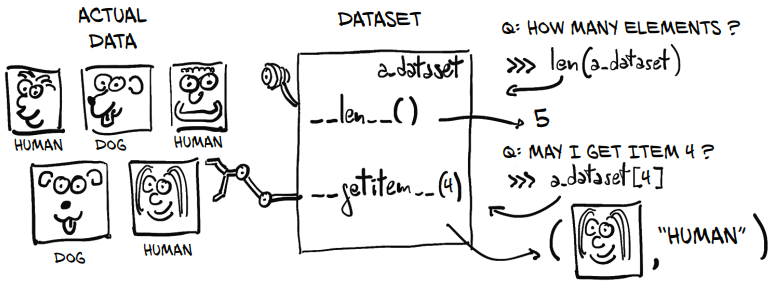

In [3]:
len(cifar10)
# if Python object is equipped with __len__ method, can use len(*) function

50000

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

img, label = cifar10[99]
img, label, class_names[label]
# if python object is equipped with __getitem__ method, can use index to access individual items

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FF5C8378BE0>,
 1,
 'automobile')

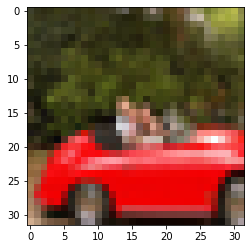

In [5]:
plt.imshow(img)

## Image Preprocessing

Use torchvision.transforms to transform data after it is loaded but before it is returned by \_\_getitem__.

In [6]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [7]:
# turns Numpy arrays and PIL images to pytorch tensors. Automatically lay out the output tensor dimension to C*H*W.
img_t = transforms.ToTensor()(img)
img_t.shape

torch.Size([3, 32, 32])

In [8]:
# transform entire picture set into tensors
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                  transform=transforms.ToTensor())

In [9]:
# accessing dataset element returns tensor rather than image
img_t, _ = tensor_cifar10[99]
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [10]:
# ToTensor also scaling the color range 0-255 to floating point from 0.0 to 1.0
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

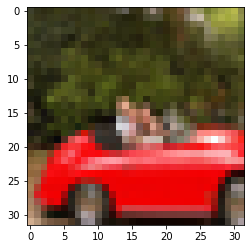

In [11]:
plt.imshow(img_t.permute(1, 2, 0)) # changes the order of the axes from C*H*W to H*W*C to match what matplotlib expects
plt.show()

In [12]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [17]:
imgs.view(3, -1).mean(dim=1), imgs.view(3, -1).std(dim=1)
# view(3, -1) keeps one 3 element dimension, and merges all the remaining dimensions into one
# the resulting mean and std are the for each color channel RGB

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [18]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [19]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
    ])
)

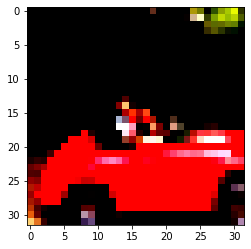

In [20]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [45]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                            (0.2470, 0.2435, 0.2616))
    ])
)

In [46]:
# Reduce the dataset to only 2 labels
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in [0, 2]]

In [34]:
def softmax(x):
  return torch.exp(x) / torch.exp(x).sum()

In [35]:
# elements of the output must be in the 0-1 range
# elements of the output must add up to 1
softmax = nn.Softmax(dim=1) # can specify the dimension to encode probabilities along
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [36]:
import torch.nn as nn

model = nn.Sequential(
  nn.Linear(3072, 512), # 32*32*3
  nn.Tanh(),
  nn.Linear(512, 2),
  nn.Softmax(dim=1) # represent the classification output as probabilities
)

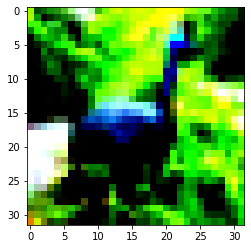

In [48]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [49]:
img_batch = img.view(-1).unsqueeze(0) # change 3*32*32 to 3072
out = model(img_batch)
out
# at this point the model is not trained, it is the result after random parameterization

tensor([[0.5139, 0.4861]], grad_fn=<SoftmaxBackward0>)

In [51]:
_, index = torch.max(out, dim=1) # return the dimension largest probability
index

tensor([0])

In [ ]:
# Update parameter with each individual samples
# import torch
# import torch.nn as nn
# from torch import optim

# model = nn.Sequential(
#   nn.Linear(3072, 512), # 32*32*3
#   nn.Tanh(),
#   nn.Linear(512, 2),
#   nn.LogSoftmax(dim=1)) # log of probability + softmax (log is tricky when prob goes to 0)
# learning_rate = 1e-2
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# loss_fn = nn.NLLLoss() # negative log likelihood function NLL=-sum(log(out[class]))
# n_epochs = 100

# for epoch in range(n_epochs):
#   for img, label in cifar2:
#     out = model(img.view(-1).unsqueeze(0))
#     loss = loss_fn(out, torch.tensor([label]))

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#   print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [55]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
  nn.Linear(3072, 512),
  nn.Tanh(),
  nn.Linear(512, 2),
  nn.LogSoftmax(dim=1)) 
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss() # negative log likelihood function NLL=-sum(log(out[class]))
n_epochs = 100

for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    # in each iteration, imgs is a tensor of size 64*3*32*32
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.485658
Epoch: 1, Loss: 0.265207
Epoch: 2, Loss: 0.437404
Epoch: 3, Loss: 0.393062
Epoch: 4, Loss: 0.473155
Epoch: 5, Loss: 0.737306
Epoch: 6, Loss: 0.343948
Epoch: 7, Loss: 0.313953
Epoch: 8, Loss: 0.386073
Epoch: 9, Loss: 0.289813
Epoch: 10, Loss: 0.499714
Epoch: 11, Loss: 0.226387
Epoch: 12, Loss: 0.286299
Epoch: 13, Loss: 0.219172
Epoch: 14, Loss: 0.301390
Epoch: 15, Loss: 0.485989
Epoch: 16, Loss: 0.179715
Epoch: 17, Loss: 0.473475
Epoch: 18, Loss: 0.647575
Epoch: 19, Loss: 0.522589
Epoch: 20, Loss: 0.195739
Epoch: 21, Loss: 0.353944
Epoch: 22, Loss: 0.153703
Epoch: 23, Loss: 0.224586
Epoch: 24, Loss: 0.196112
Epoch: 25, Loss: 0.181548
Epoch: 26, Loss: 0.171194
Epoch: 27, Loss: 0.285247
Epoch: 28, Loss: 0.101336
Epoch: 29, Loss: 0.122701
Epoch: 30, Loss: 0.179166
Epoch: 31, Loss: 0.107057
Epoch: 32, Loss: 0.092623
Epoch: 33, Loss: 0.178853
Epoch: 34, Loss: 0.305233
Epoch: 35, Loss: 0.134123
Epoch: 36, Loss: 0.276705
Epoch: 37, Loss: 0.205938
Epoch: 38, Loss: 0.139

In [56]:
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8165


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.490328
Epoch: 1, Loss: 0.622316
Epoch: 2, Loss: 0.540501
Epoch: 3, Loss: 0.376723
Epoch: 4, Loss: 0.390589
Epoch: 5, Loss: 0.487945
Epoch: 6, Loss: 0.243674
Epoch: 7, Loss: 0.328772
Epoch: 8, Loss: 0.346514
Epoch: 9, Loss: 0.558839
Epoch: 10, Loss: 0.445842
Epoch: 11, Loss: 0.223532
Epoch: 12, Loss: 0.431945
Epoch: 13, Loss: 0.478797
Epoch: 14, Loss: 0.288486
Epoch: 15, Loss: 0.415954
Epoch: 16, Loss: 0.344930
Epoch: 17, Loss: 0.149925
Epoch: 18, Loss: 0.464428
Epoch: 19, Loss: 0.105365
Epoch: 20, Loss: 0.148880
Epoch: 21, Loss: 0.260261
Epoch: 22, Loss: 0.354884
Epoch: 23, Loss: 0.197338
Epoch: 24, Loss: 0.405397
Epoch: 25, Loss: 0.307265
Epoch: 26, Loss: 0.216252
Epoch: 27, Loss: 0.377882
Epoch: 28, Loss: 0.055613
Epoch: 29, Loss: 0.248415
Epoch: 30, Loss: 0.048558
Epoch: 31, Loss: 0.127236
Epoch: 32, Loss: 0.188101
Epoch: 33, Loss: 0.045827
Epoch: 34, Loss: 0.041671
Epoch: 35, Loss: 0.153856
Epoch: 36, Loss: 0.128427
Epoch: 37, Loss: 0.039943
Epoch: 38, Loss: 0.481

In [69]:
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print("Accuracy: %f", correct / total)

Accuracy: %f 0.8025


In [63]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])